<a href="https://colab.research.google.com/github/Iksan03/DeepLearning/blob/main/Week12-Python-WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
layers = keras.layers

print("tensorflow version", tf.__version__)
print("keras version", keras.__version__)
print("numpy version", np.__version__)

tensorflow version 2.8.2
keras version 2.8.0
numpy version 1.21.6


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found. If you use google colab, request a GPU via "Edit" --> "Notebook Settings"')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import gdown

url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz"
output = 'airshowers.npz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz
To: /content/airshowers.npz
100%|██████████| 65.6M/65.6M [00:00<00:00, 66.2MB/s]


'airshowers.npz'

In [5]:
file = np.load(output)
shower_maps = file['shower_maps']
nsamples = len(shower_maps)

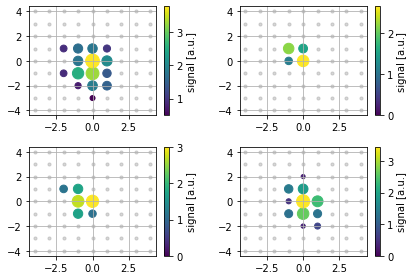

In [6]:
def rectangular_array(n=9):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)


for i,j in enumerate(np.random.choice(nsamples, 4)):
    plt.subplot(2,2,i+1)
    footprint=shower_maps[j,...,0]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                           s=marker_size, alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('signal [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
def generator_model(latent_size):
    """ Generator network """
    latent = layers.Input(shape=(latent_size,), name="noise")
    z = layers.Dense(9 * 9 * latent_size)(latent)
    z = layers.Reshape((9, 9, latent_size))(z)
    z = layers.Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(z)
    return keras.models.Model(latent, z, name="generator")

In [8]:
latent_size = 128
g = generator_model(latent_size)
g.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 10368)             1337472   
                                                                 
 reshape (Reshape)           (None, 9, 9, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 1)           1153      
                                                                 
Total params: 1,338,625
Trainable params: 1,338,625
Non-trainable params: 0
_________________________________________________________________


In [9]:
def critic_model():
    image = layers.Input(shape=(9,9,1), name="images")
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(9, 9, 1))(image)
    x = layers.LeakyReLU()(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(100)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(1)(x)
    return keras.models.Model(image, x, name="critic")

In [10]:
critic = critic_model()
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 9, 9, 1)]         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 9, 9, 64)          0         
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               6500      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                            

In [11]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:
        # print(type(layer))
        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

In [12]:
make_trainable(critic, False) 
make_trainable(g, True) # This is in principal not needed here

In [13]:
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, critic(g(gen_input)))
generator_training.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 generator (Functional)      (None, 9, 9, 1)           1338625   
                                                                 
 critic (Functional)         (None, 1)                 7241      
                                                                 
Total params: 1,345,866
Trainable params: 1,338,625
Non-trainable params: 7,241
_________________________________________________________________


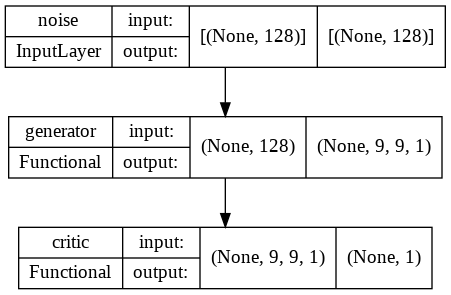

In [14]:
keras.utils.plot_model(generator_training, show_shapes=True)

In [15]:
import tensorflow.keras.backend as K

def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss - critic maximises the distance between its output for real and generated samples.
    To achieve this generated samples have the label -1 and real samples the label 1. Multiplying the outputs by the labels results to the wasserstein loss via the Kantorovich-Rubinstein duality"""
    return K.mean(y_true * y_pred)

generator_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss])

In [16]:
BATCH_SIZE = 64

class UniformLineSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        weights = K.random_uniform((self.batch_size, 1, 1, 1))
        return(weights * inputs[0]) + ((1 - weights) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [17]:
make_trainable(critic, True)  # unfreeze the critic during the critic training
make_trainable(g, False)  # freeze the generator during the critic training

g_out = g(g.inputs)
critic_out_fake_samples = critic(g_out)
critic_out_data_samples = critic(critic.inputs)
averaged_batch = UniformLineSampler(BATCH_SIZE)([g_out, critic.inputs[0]])
averaged_batch_out = critic(averaged_batch)

critic_training = keras.models.Model(inputs=[g.inputs, critic.inputs], outputs=[critic_out_fake_samples, critic_out_data_samples, averaged_batch_out])

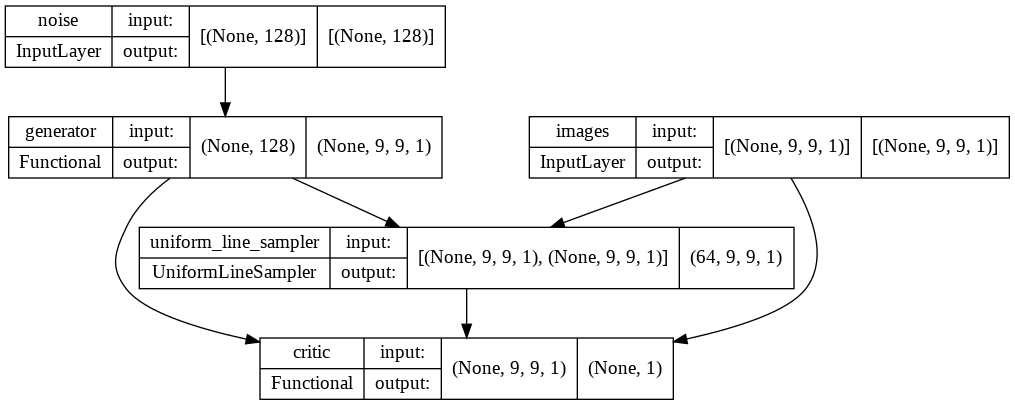

In [18]:
keras.utils.plot_model(critic_training, show_shapes=True)

In [19]:
critic_training.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 generator (Functional)         (None, 9, 9, 1)      1338625     ['noise[0][0]']                  
                                                                                                  
 images (InputLayer)            [(None, 9, 9, 1)]    0           []                               
                                                                                                  
 uniform_line_sampler (UniformL  (64, 9, 9, 1)       0           ['generator[1][0]',              
 ineSampler)                                                      'images[0][0]']           

In [20]:
from functools import partial

def gradient_penalty_loss(y_true, y_pred, averaged_batch, penalty_weight):
    """Calculates the gradient penalty.
    The 1-Lipschitz constraint of improved WGANs is enforced by adding a term that penalizes a gradient norm in the critic unequal to 1."""
    gradients = K.gradients(y_pred, averaged_batch)
    gradients_sqr_sum = K.sum(K.square(gradients)[0], axis=(1, 2, 3))
    gradient_penalty = penalty_weight * K.square(1 - K.sqrt(gradients_sqr_sum))
    return K.mean(gradient_penalty)


gradient_penalty = partial(gradient_penalty_loss, averaged_batch=averaged_batch, penalty_weight=10)  # construct the gradient penalty
gradient_penalty.__name__ = 'gradient_penalty'

In [21]:
critic_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss, wasserstein_loss, gradient_penalty])

In [22]:
positive_y = np.ones(BATCH_SIZE)
negative_y = -positive_y
dummy = np.zeros(BATCH_SIZE)  # keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss

In [23]:
EPOCHS = 1
critic_iterations = 1

generator_loss = []
critic_loss = []

iterations_per_epoch = nsamples // (critic_iterations * BATCH_SIZE)
iters = 0

for epoch in range(EPOCHS):
    print("epoch: ", epoch)  
    
    for iteration in range(iterations_per_epoch):

        for j in range(critic_iterations):

            noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
            shower_batch = shower_maps[BATCH_SIZE*(j+iteration):BATCH_SIZE*(j++iteration+1)]  # take batch of shower maps
            critic_loss.append(critic_training.train_on_batch([noise_batch, shower_batch], [negative_y, positive_y, dummy]))  # train the critic

        noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
        generator_loss.append(generator_training.train_on_batch([noise_batch], [positive_y]))  # train the generator
        iters+=1
        
        generated_maps = g.predict_on_batch(np.random.randn(BATCH_SIZE, latent_size))
        
        if iters % 100 == 1:
            print("iteration", iters)
            print("critic loss:", critic_loss[-1])
            print("generator loss:", generator_loss[-1])

            for i in range(4):
                plt.subplot(2,2,i+1)
                footprint=generated_maps[i,...,0]
                xd, yd = rectangular_array()
                mask = footprint != 0
                mask[5, 5] = True
                marker_size = 50 * footprint[mask]
                plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
                circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                                       s=marker_size, alpha=1, label="loud")
                cbar = plt.colorbar(circles)
                cbar.set_label('signal [a.u.]')
                plt.grid(True)

            plt.suptitle("iteration %i" % iters)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig("./fake_showers_iteration_%.6i.png" % iters)
            plt.close("all")

epoch:  0


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


iteration 1
critic loss: [1.7266822, -0.6598102, 1.1395005, 1.2469919]
generator loss: 0.653839
iteration 101
critic loss: [-3.2301974, 1.572898, -5.440238, 0.63714254]
generator loss: -1.5873728
iteration 201
critic loss: [-2.629353, 1.8608427, -4.734243, 0.2440472]
generator loss: -2.2608242
iteration 301
critic loss: [-1.0326679, 1.9404476, -3.1823668, 0.20925137]
generator loss: -1.6631079
iteration 401
critic loss: [-0.49974906, 0.053070195, -0.79694057, 0.24412131]
generator loss: -0.3899722
iteration 501
critic loss: [0.32766038, 1.2226596, -1.1609384, 0.26593918]
generator loss: -1.5089767
iteration 601
critic loss: [0.7876036, 2.7203336, -2.1142814, 0.18155149]
generator loss: -2.386523
iteration 701
critic loss: [0.040981278, 2.1531992, -2.2314875, 0.119269595]
generator loss: -2.3534782
iteration 801
critic loss: [0.47070462, -2.7742407, 3.0941844, 0.15076093]
generator loss: 2.7596135
iteration 901
critic loss: [0.18451723, -1.6806021, 1.6967465, 0.16837284]
generator loss:

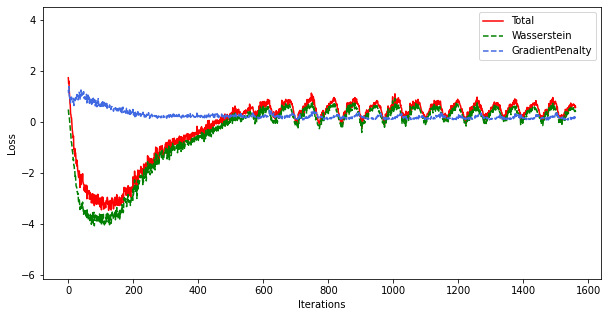

In [24]:
critic_loss = np.array(critic_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 0], color='red', markersize=12, label=r'Total')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 1] + critic_loss[:, 2], color='green', label=r'Wasserstein', linestyle='dashed')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 3], color='royalblue', markersize=12, label=r'GradientPenalty', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.ylim(np.min(critic_loss)-0.5, 4.5)
plt.show()

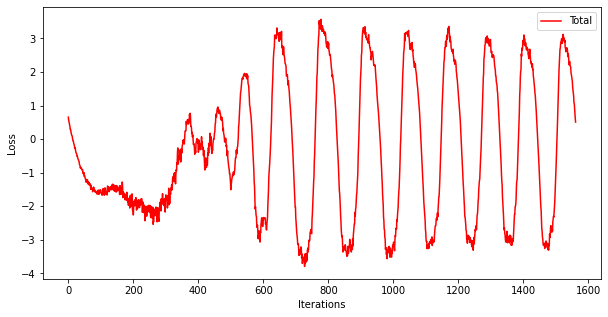

In [25]:
generator_loss = np.array(generator_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(generator_loss)), generator_loss, color='red', markersize=12, label=r'Total')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.show()

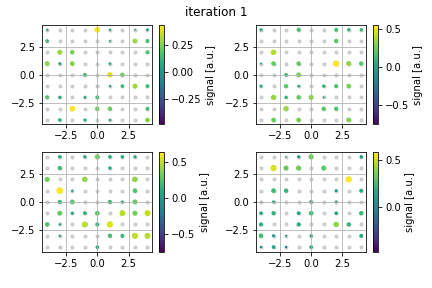

In [26]:
import imageio
import glob

out_file = 'generated_shower_samples.gif'

with imageio.get_writer(out_file, mode='I', duration=0.5) as writer:
    file_names = glob.glob('fake_showers_iteration_*.png')
    file_names = sorted(file_names)
    last = -1

    for i, file_name in enumerate(file_names):
        animated_image = imageio.imread(file_name)
        writer.append_data(animated_image)

    animated_image = imageio.imread(file_name)
    writer.append_data(animated_image)

from IPython.display import Image
Image(open('generated_shower_samples.gif','rb').read())

In [27]:
!ls -F --color

airshowers.npz                     fake_showers_iteration_000901.png
fake_showers_iteration_000001.png  fake_showers_iteration_001001.png
fake_showers_iteration_000101.png  fake_showers_iteration_001101.png
fake_showers_iteration_000201.png  fake_showers_iteration_001201.png
fake_showers_iteration_000301.png  fake_showers_iteration_001301.png
fake_showers_iteration_000401.png  fake_showers_iteration_001401.png
fake_showers_iteration_000501.png  fake_showers_iteration_001501.png
fake_showers_iteration_000601.png  generated_shower_samples.gif
fake_showers_iteration_000701.png  model.png
fake_showers_iteration_000801.png  sample_data/
